In [1]:
import requests
from IPython.core.display import HTML
HTML(f"""
<style>
@import "https://cdn.jsdelivr.net/npm/bulma@0.9.4/css/bulma.min.css";
</style>
""")

# Data Preprocessing

**Overview**
This exercise is about finding the pupil centers in videos of eyes and is a prerequisite for the first mandatory assignment. You will furthermore use the data in subsequent exercises.
After the recording session you were provided with a folder containing your `.mp4`
 recordings as well as the corresponding patterns and screen coordinates. Furthermore you have also been provided with two folders `test_subject_1`
 and `test_subject_3`
 containing similar data, collected from two different test subjects. `test_subject_1`
 and `test_subject_3`
 are also located in the folder `test_subjects`
.
This notebook contains necessary functions to visualize and preprocess the videos. The videos were collected using the **[Pupil Labs Neon eye tracking module](https://pupil-labs.com/products/neon)
** while the test subjects were given four different tasks gazing at _grid_, _ellipse_, _line_ and _random_ pattern.

The following steps are about visualization and preprocessing your eye tracking data collected for the assignement. Preprocessing is an important factor for the performance of the model. 
This exercise is about:
- Visualization of the data.
- Preprocessing.    - Frame extraction.
    - Pupil center detection.
    - Determine mean pupil center for each gaze coordinate on the screen.



The following tasks introduce you to the data set of `test_subject_0`
. This dataset has been preprocessed and should give you some hints of how you can preprocess your data for the assignment.

**Important**
This exercise requires an installation of [OpenCV](https://opencv.org)
, you can use either pip or conda to install the library. Use either:
- pip install opencv-python
- conda install opencv


## Visualization
Let's get familiar with the data by visualising it. 
The data set of `test_person_0`
 contains  four subsets $\mathcal{D}_{p0}, \mathcal{D}_{p1}, \mathcal{D}_{p2}, \mathcal{D}_{p3}$ each containing a recording session using a web camera. The sources for each dataset are found in the subfolders of the `data/test_subjects/test_subject_0/gaze`
 folder. 

**Details about the data format**
Each dataset, $\mathcal{D}_i$, contains a dictionary of training and test data.
**Dataset elements:**
- `pupils_n_train`
: Normalized pupil positions for the 9 calibration images (an $9 \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `pupils_n_test`
: Normalized pupil positions for the test images (an $N \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `pupils_train`
: Pupil positions for the 9 calibration images (an $9 \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `pupils_test`
: Pupil positions for the test images (an $N \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `screen_coordinates_train`
: Screen target positions for the 9 calibration images ($9 \times 2$ array containing x,y pixel position for the target on the screen).
- `screen_coordinates_test`
: Screen target positions for the test images ($N \times 2$ array containing x,y pixel position of the target on the screen, where $N$ is the amount of test images).
- `images_train`
: 9 calibration images (an array containing 9 images).
- `images_test`
: Test images (an array containing $N$ test images).



**Info**
The `iml_util.py`
 contains functions for visualization of eye tracking data. It is not expected that you understand the implementation. 


---
**Task 1 (easy): Visualisation 1👩‍💻**
1. Run the two cells below to visualize the data set of `test_subject_0`
.
2. Test the visualisation for different datasets $\mathcal{D}_{pi}$ (by changing the array index `D[i]`
 when accessing images, positions, and pupils).


---

In [2]:
import iml_util
import numpy as np

D = iml_util.gen_data_subject_0()

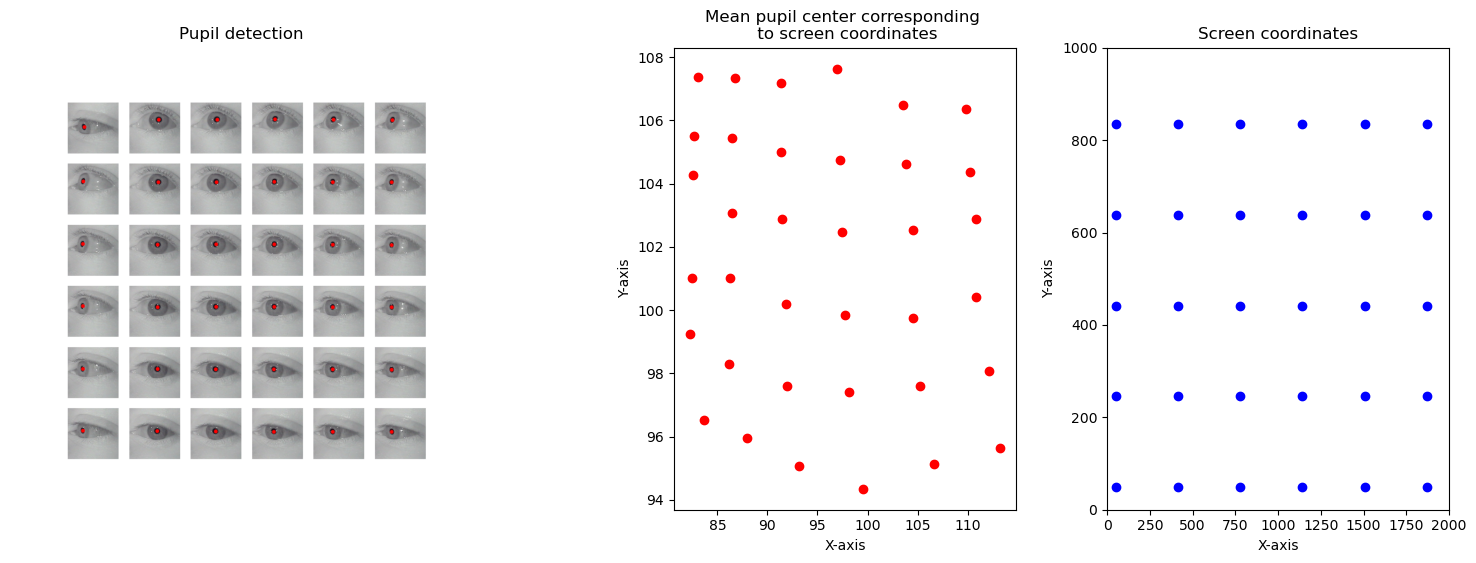

In [3]:
dataset = D[0] #change this index to show the different sessions

grid = iml_util.create_image_grid_viz(dataset)
iml_util.image_and_scatter(grid, dataset)

## Preprocessing
In the following steps, you will be using the data set of `test_subject_3`
 as well as the data that you collected.

**Info**
A common challenge in machine learning is the presence of noise, which can corrupt data and impact the reliability of feature extraction. This issue is also relevant to the data collected for this assignment. If you encounter unreliable feature extraction, it is recommended to use the dataset from `test_subject_1`
.


---
**Task 2 (easy): Setup💡**
1. Describe the setup of the data collection was performed. Reflect on any pitfalls in the setup that may contribute to noisy data. What are the challenges of having multiple test subjects?


---

In [4]:
#Write your reflection here...

## Frame extraction

---
**Task 3 (easy): Frame extraction👩‍💻**
1. Paste the folder containing your data to the `data/test_subjects`
 folder.
2. Run the cell below to extract frames for `test_person_3`
. 
3. Observe that the extracted frames will be placed in the `output`
 folder.


**Important**
Note that the output folder should only contain frames extracted from a single `.mp4`
 file. Do not mix patterns and subjects into the same folder.

4. Update the variable `folder_name`
 to `test_person_1`
 and rerun the cell. 
5. Update the variable `folder_name`
 to your data and rerun the cell. 
6. Update the `folder_name`
 and `video_name`
 to produce folders of frames for each test person for each pattern.


---

In [5]:
# Extract frames from the video
folder_name = 'test_subject_1'
video_name = 'circle'
output_folder = folder_name
video_file =f"data/test_subjects/{folder_name}/{video_name}.mp4"
output_directory = f"data/output/{output_folder}/{video_name}"
iml_util.extract_frames(video_file, output_directory)

Extracted 667 frames from data/test_subjects/test_subject_1/circle.mp4 to data/output/test_subject_1/circle


## Pupil center coordinate extraction
With the frames now located in the `output`
 folder, the next step is to preprocess the frames. The following cell contains the function, `pupil_detection`
, to detect pupils in images.

**Info**
You are not expected to understand the implementation in details. 

While there are multiple approaches to pupil pupil detection, Carl Coder has made a pupil detection method using relatively simple means, designed to be transparent and intuitive to follow. As you will experience the method is not the most efficient or precise, and requires individual adjustments for each dataset.
The data preprocessing contains the following steps:
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: right; width: 35%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="pupil_detection">

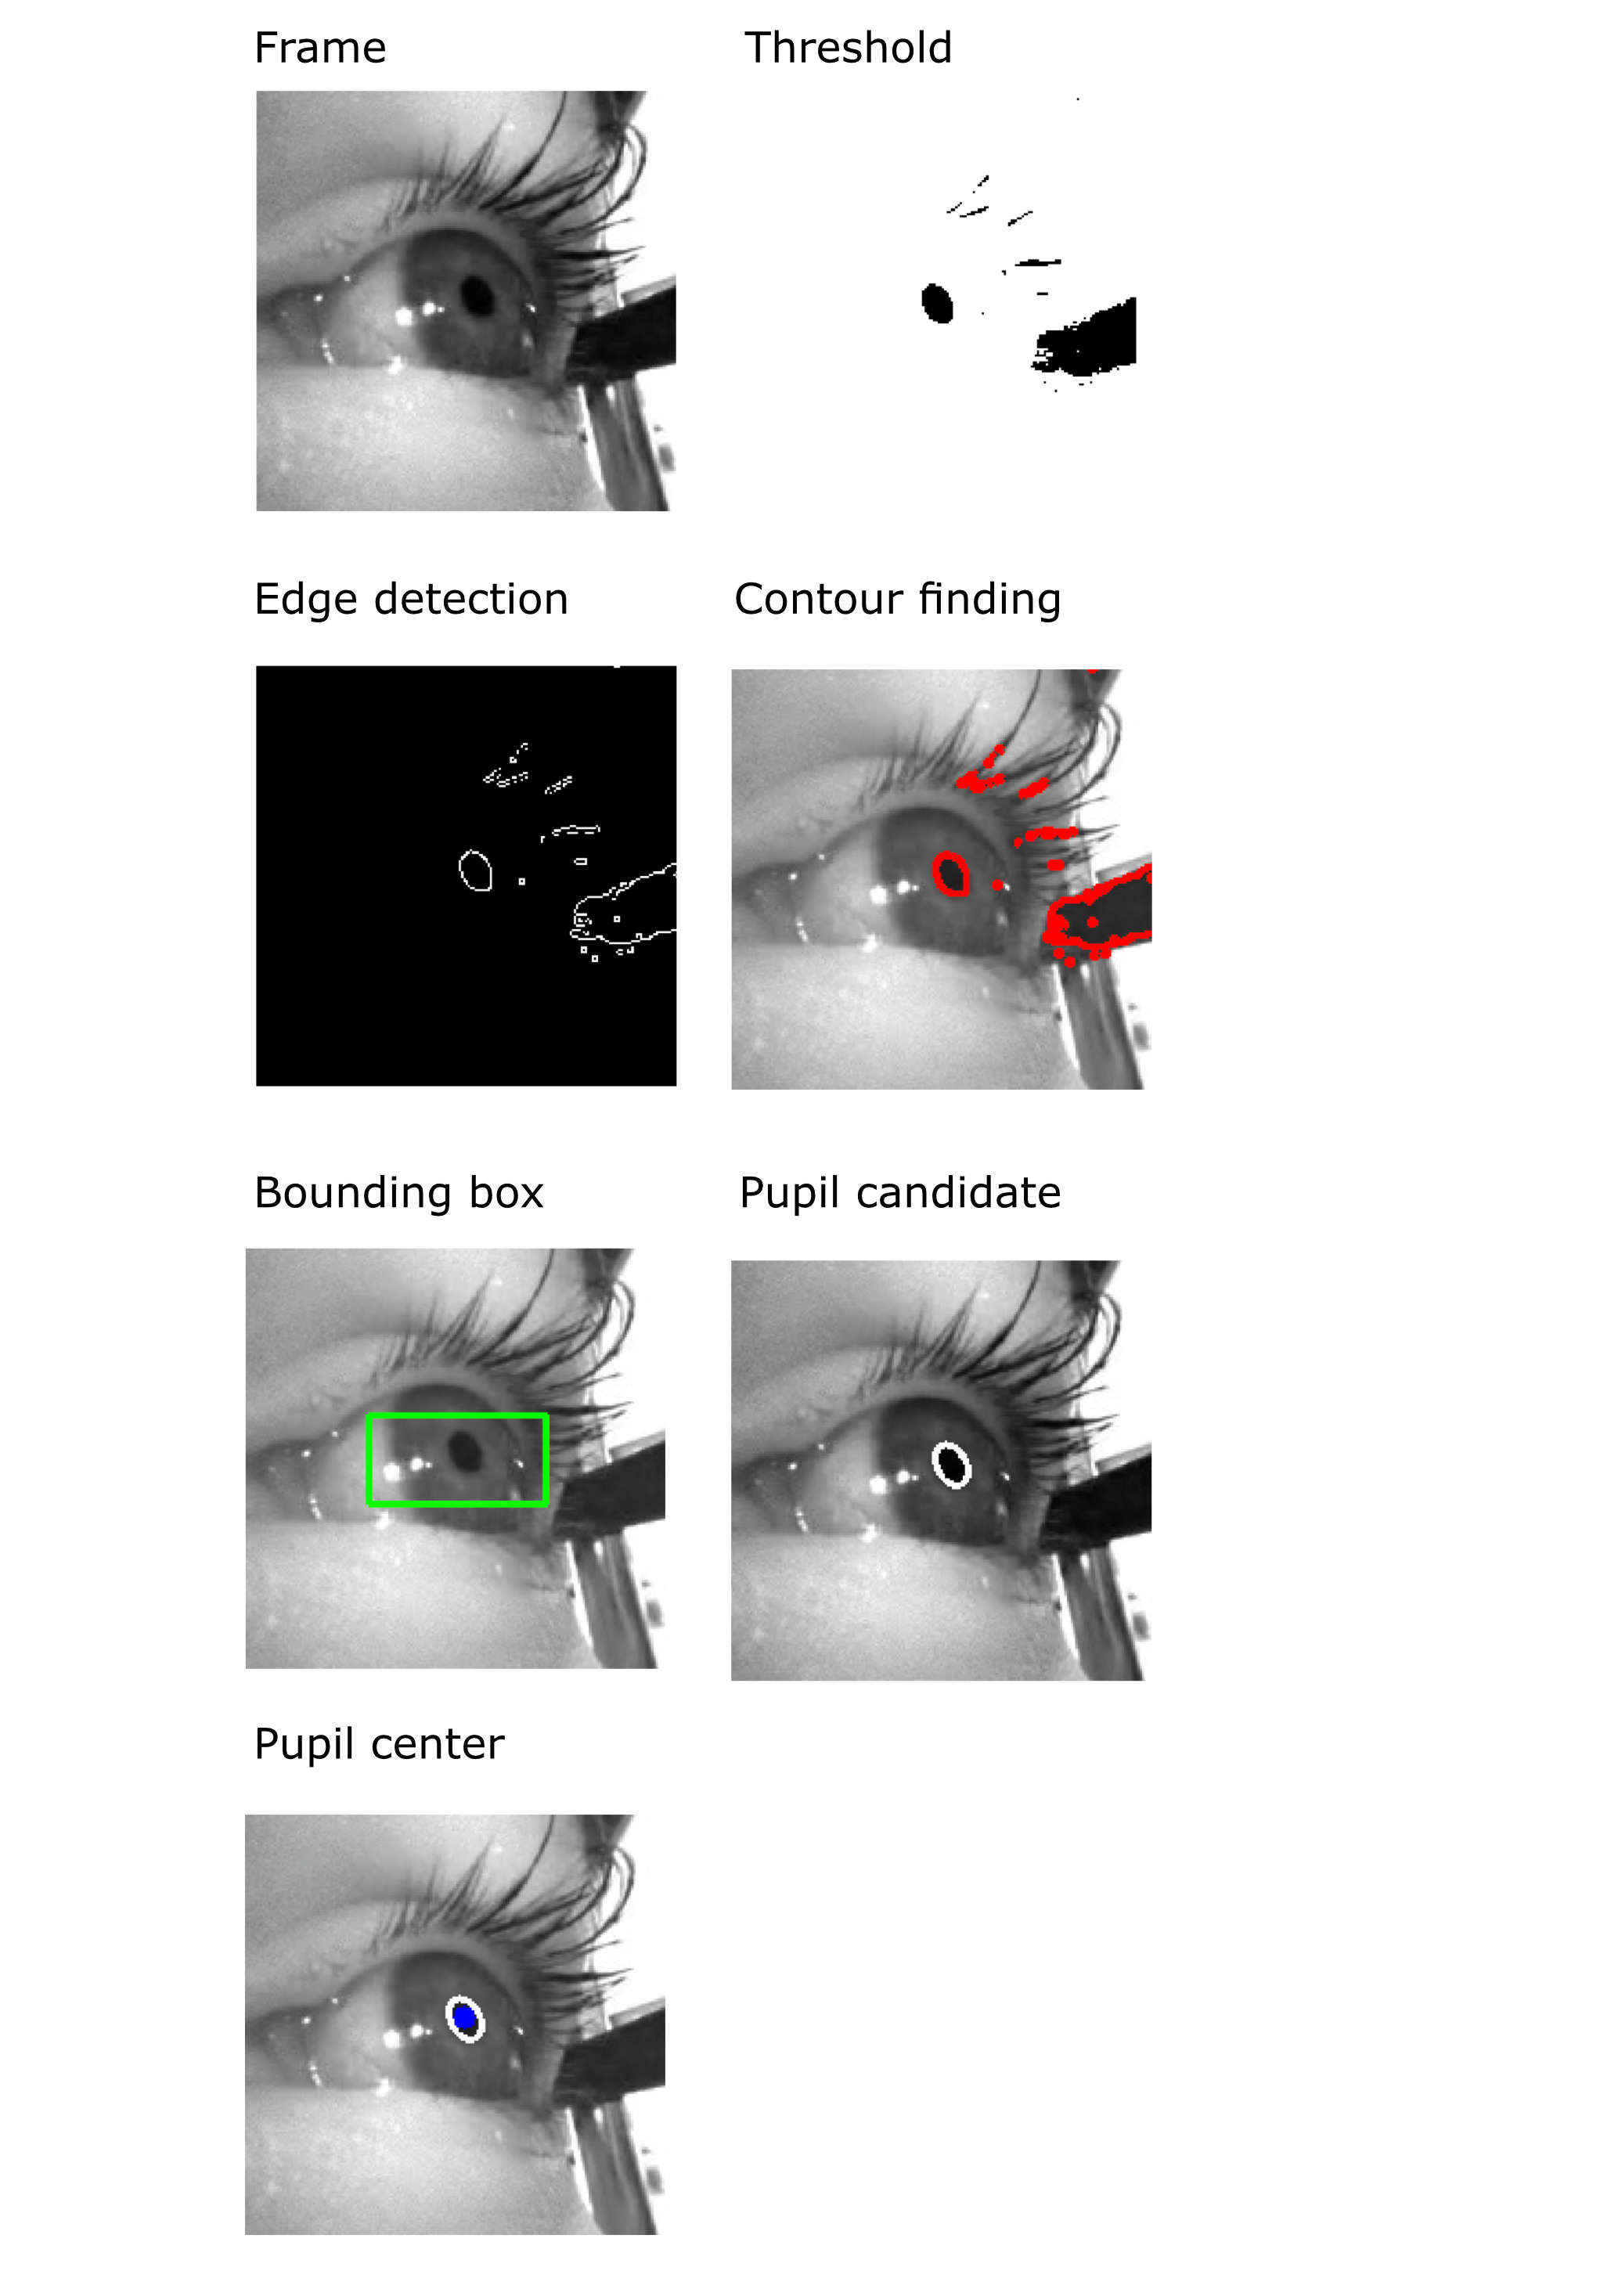

<figcaption class="figure-caption has-text-right">Figure 1: Visualization of the processing steps of finding the pupil center coordinate
</figcaption>
</figure>
</div>


</div>

<div style="float: left; width: 65%; justify-content: start" class="block is-clearfix">

- Threshold value
    - Thresholding the image to highlight potential pupil regions according to intensity


- Edge Detection
    - Detect edges in the thresholded image using the Canny edge detector.


- Contour Detection
    - Find contours within the edge-detected image.


- Ellipse Fitting
    - Fit ellipses to the detected contours that meet specific criteria (e.g., aspect ratio).


- Pupil Center Detection
    - Identify the most likely pupil center based on ellipse fitting within a defined bounding box.





</div>



</div>

For the best result you have to adapt the inputs to the method in accordence to each dataset. These values include _threshold_value_, _x_margin_, and _y_margin_. The _x_margin_ and _y_margin_ define a bounding box within pupil candidates are searched. This method is effective as the Pupil Labs eye-tracking glasses keep the eyes stationaty in the image with respect to the camera. See figure [Figure 1](#pupil_detection) for the effect each of them apply. 


In [6]:
def pupil_detection(img, threshold_value, eye, debug, 
                    x_margin, y_margin, min_minor_axis=10, max_minor_axis=25):

    """
    This function processes an image to detect the pupil's center using various image processing techniques such as thresholding, 
    edge detection, and contour analysis.
    
    Parameters:
        img (numpy.ndarray): The input grayscale image of an eye.
        threshold_value (int): The threshold value used for binarizing the image.
        eye (str): Indicates whether the input image is of the left or right eye ('l' for left, 'r' for right). Default is 'l'.
        debug (bool): If True, intermediate processing steps will be displayed using Matplotlib. Default is False.
        x_margin (int): The horizontal margin for cropping the eye region. Default is 40.
        y_margin (int): The vertical margin for cropping the eye region. Default is 20.
        min_minor_axis (int): The minimum allowable length for the minor axis of the detected ellipse. Default is 10.
        max_minor_axis (int): The maximum allowable length for the minor axis of the detected ellipse. Default is 25.
    
    Returns:
        tuple: The (x, y) coordinates of the pupil's center if detected; otherwise, returns None.
    """
    
    img_copy = img.copy()
    img_color = iml_util.cv.cvtColor(img_copy, iml_util.cv.COLOR_GRAY2BGR)
    
    if debug:
        iml_util.show_image('Frame', img_copy)
    
    # Step 1: Apply threshold
    ret, thresh = iml_util.cv.threshold(img_copy, threshold_value, 255, iml_util.cv.THRESH_BINARY)
    if debug:
        iml_util.show_image('Threshold Image', thresh)
    
    # Step 2: Detect edges
    edges = iml_util.cv.Canny(thresh, 100, 200)
    if debug:
        iml_util.show_image('Edges Image', edges)
    
    # Step 3: Find contours
    contours, _ = iml_util.cv.findContours(edges, iml_util.cv.RETR_EXTERNAL, iml_util.cv.CHAIN_APPROX_SIMPLE)
    if debug:
        img_contours = img_color.copy()
        iml_util.cv.drawContours(img_contours, contours, -1, (255, 0, 0), 2)
        iml_util.show_image('Contours Image', img_contours)
    
    h, w = img.shape
    center = (0, 0)
    ellipses = []
    
    # Step 5: Draw the bounding box
    top_left = (int(w/2) - x_margin, int(h/2) - y_margin)
    bottom_right = (int(w/2) + x_margin, int(h/2) + y_margin)
    iml_util.cv.rectangle(img_color, top_left, bottom_right, (0, 255, 0), 2)
    if debug:
        iml_util.show_image('Bounding Box Image', img_color)

    # Step 6: Fit ellipses to the contours and filter based on criteria
    for c in contours:
        if len(c) >= 15:
            ellipse = iml_util.cv.fitEllipse(c)
            major_axis, minor_axis = ellipse[1]
            aspect_ratio = major_axis / minor_axis
            
            if 0.2 <= aspect_ratio <= 1:
                ellipses.append(ellipse)
                
    for e in ellipses:
        if (int(w/2) - x_margin < e[0][0] < int(w/2) + x_margin and 
            int(h/2) - y_margin < e[0][1] < int(h/2) + y_margin and 
            min_minor_axis < e[1][1] < max_minor_axis):
            center = (e[0][0], e[0][1])
            iml_util.cv.ellipse(img_copy, e, (255, 255, 255), 2)
            if debug:
                iml_util.show_image('Detected Ellipse', img_copy)
                
            # Draw the found center point
            img_color = iml_util.cv.cvtColor(img_copy, iml_util.cv.COLOR_GRAY2BGR)
            iml_util.cv.circle(img_color, (int(center[0]), int(center[1])), 5, (0, 0, 255), -1)
            if debug:
                iml_util.show_image('Detected Ellipse with Center', img_color)
    
    return center if center != (0, 0) else None

The cell below contains the main function for extacting the pupil features and the parameters to extract them. Pay attention to the `debug`
 option which will help you visualize the effect of each step and identify how to adjust the parameters.

---
**Task 4 (easy): Pupil detection👩‍💻**
_Your task is to experiment with the parameters to optimize pupil detection for your specific dataset. While it is not expected that you elaborate on the code, you are encouraged to examine it. A debug feature is provided in the parameter, which will help visualize each step in accordance to the values chosen._
1. Examine the code and familiarise yourself with the location of the parameters for adjustment.
2. Adjust the `frame_folder`
 variable to set the target frame folder for pupil center detection. 
3. Run the cell below and inspect the output in the visualized grid as well as the number of reported centers found compared to amount of images. 


**Info**
For successful pupil feature extraction from video frames, it is essential to visually recognize patterns in the pupil data plot. The number of frames processed does not determine extraction success; rather, the critical factor is the accurate mapping of pupil coordinates to corresponding screen coordinates, ensuring a pupil coordinate for each screen point.


**Important**
Note that function generates a `.csv`
 file with the pupil coordinates and the corresponding frame. The file is saved to the same `output_directory`
 in which the frames processed are saved.

4. Run the cell below and toggle `debug = True`
 for visualization of the process.
5. Experiment with the different parameter settings to obtain the best pupil center detection possible for the given dataset. 
6. Once the parameter setting is optimized, you have to run the code for each pattern, but you are only required data for one eye. Choose the side that performs best.


---Please note that the default values are tailored to the dataset of `test_person_3`
.


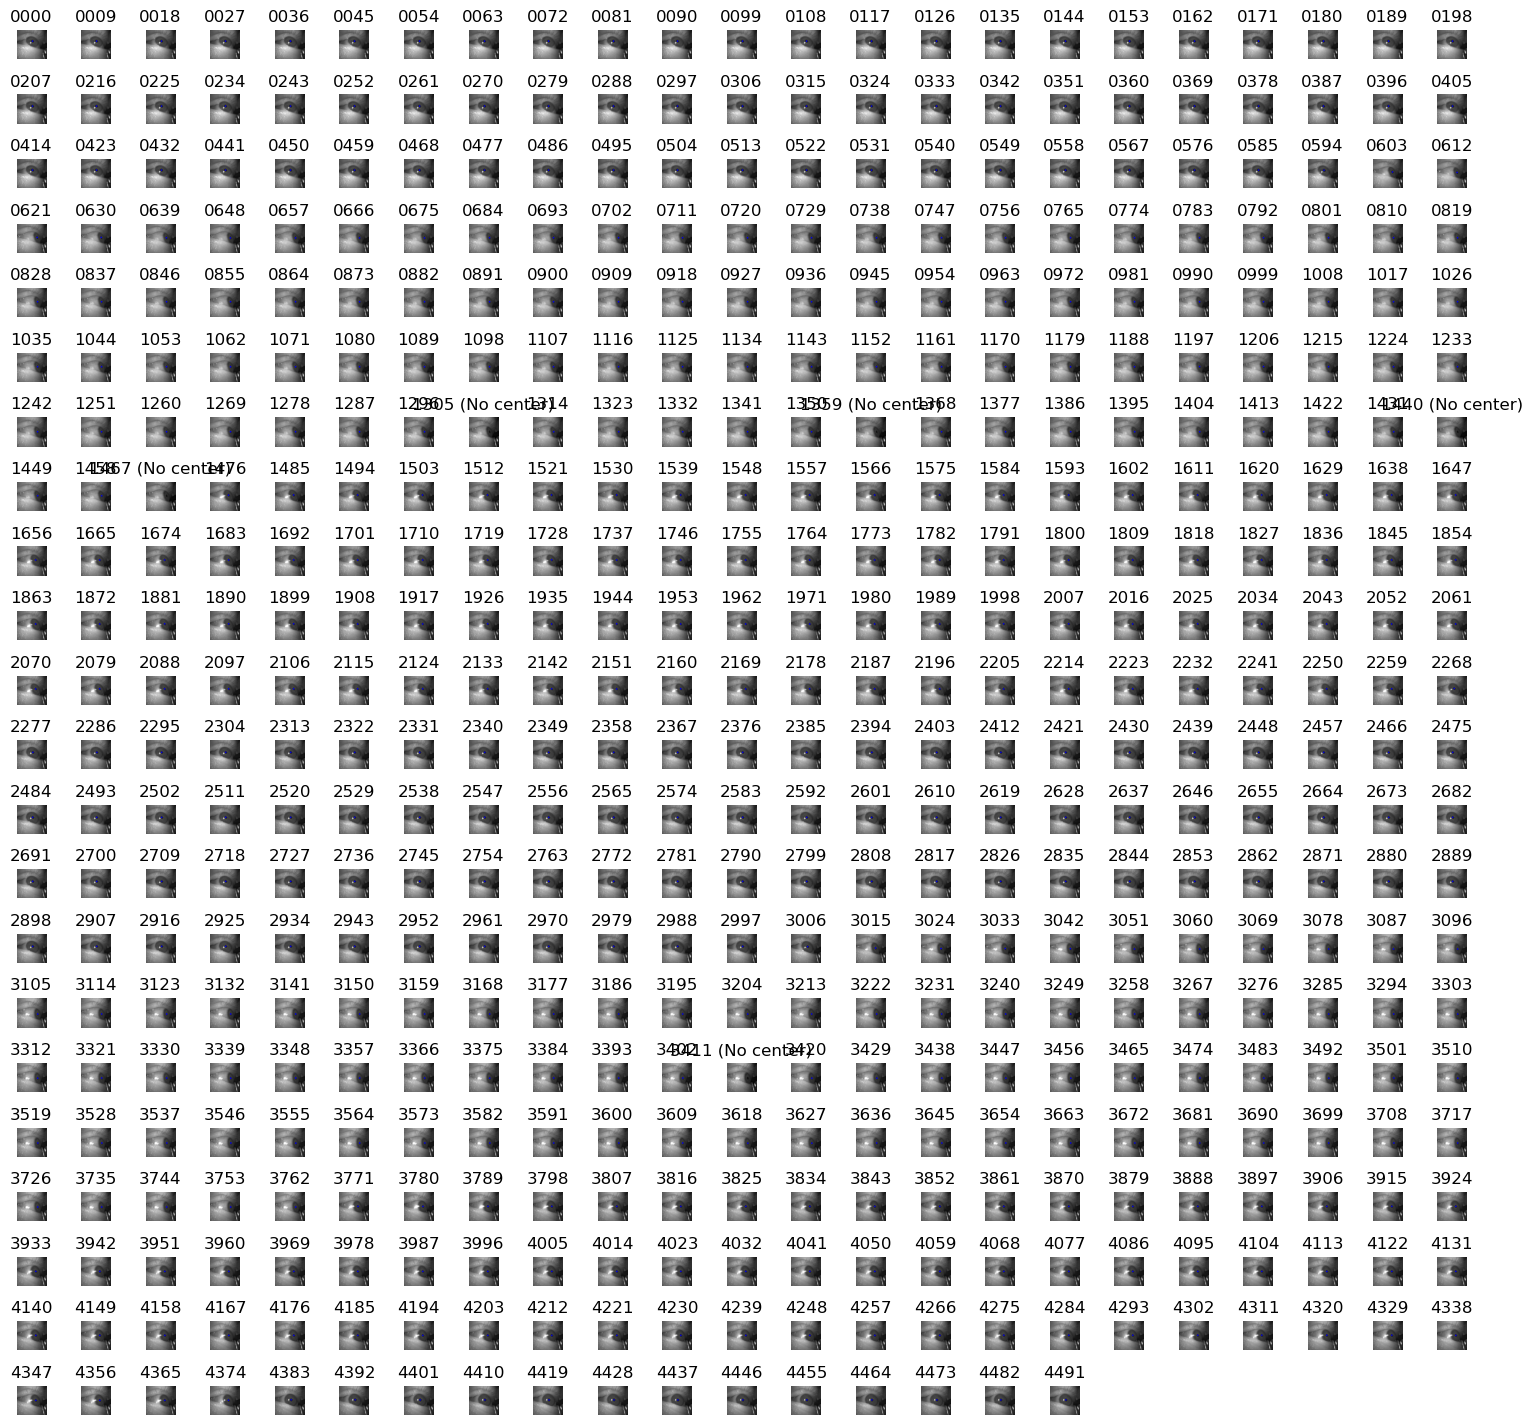

Total frames processed: 570
Number of detected centers: 565
Pupil coordinates saved to data/output/test_subject_fefa/grid/pupil_coordinates.csv


In [14]:
# Main function to process the video and detect centroids
def process_video(output_directory, threshold_value, 
                  side='left', debug=False, x_margin=40, y_margin=20):
    """
    Detect pupil centers, and create image grids.

    Parameters:
        output_directory (str): The directory where extracted frames and output data will be saved.
        threshold_value (int): The threshold value for binarizing images during pupil detection.
        side (str): Indicates which side of the image to process ('left' or 'right'). Default is 'left'.
        debug (bool): If True, debug information and images will be displayed. Default is False.
        x_margin (int): The horizontal margin for cropping the eye region. Default is 40.
        y_margin (int): The vertical margin for cropping the eye region. Default is 20.

    Returns:
        None
    """
    
    # Load the extracted eye images
    eye_images = iml_util.load_images_from_folder(output_directory)
    
    # Detect centroids in the images and store results in a DataFrame
    centers = []
    data = []
    valid_images = []  # To store images where centers are found
    valid_centers = []  # To store corresponding centers
    invalid_images = []  # To store images where centers are not found

    for image_file, img in eye_images:
        left, right = iml_util.split_img(img)
        if side == 'left':
            center = pupil_detection(left, threshold_value, 'l', debug, x_margin, y_margin)
        elif side == 'right':
            center = pupil_detection(right, threshold_value, 'r', debug, x_margin, y_margin)
        else:
            raise ValueError("Invalid side parameter. Choose either 'left' or 'right'.")
            
        if center:
            centers.append(center)
            valid_images.append((image_file, img))  # Store valid images
            valid_centers.append(center)  # Store corresponding centers
            data.append({"image": image_file, "px": center[0], "py": center[1]})
        else:
            centers.append(None)  # Ensure centers list is the same length as images
            invalid_images.append((image_file, img))  # Store invalid images
    
    # Create a pandas DataFrame
    df = iml_util.pd.DataFrame(data)
    df.to_csv(iml_util.os.path.join(output_directory, "pupil_coordinates.csv"), index=False)
    
    # Generate a 10x10 grid of images with pupil centers drawn
    iml_util.create_image_grid(eye_images, centers, output_directory, side, grid_name='pupil_centers_grid', max_images=500)
    
    # the following line displays the first 100 images. Uncomment to display images 0 to 100. Change the interval to show desired images.
    #iml_util.create_image_grid(eye_images[0:100], centers, output_directory, side, grid_name='pupil_centers_grid') 

    if debug:
        # DEBUG: Generate the grid of images where centers were not found, limited to 10x10
        iml_util.create_image_grid(invalid_images, [None]*len(invalid_images), output_directory, side, grid_name='invalid_pupil_centers_grid', max_images=500)
    
    # Print results
    print(f"Total frames processed: {len(eye_images)}")
    print(f"Number of detected centers: {len([c for c in centers if c is not None])}")
    print(f"Pupil coordinates saved to {iml_util.os.path.join(output_directory, 'pupil_coordinates.csv')}")

# Experiment with parameter values
output_directory = output_directory = f"data/output/test_subject_fefa/grid"
threshold_value = 40
x_margin = 40
y_margin = 20
side = 'left'  # Change to 'left' or 'right' to show the respective side of the images
debug = False  # Set to True to see the debugging steps

process_video(output_directory, threshold_value, side, debug, x_margin, y_margin)


---
**Task 5 (easy): Pupil detection💡**
1. Reflect on the difficulties you experience, in terms of correctly detecting the pupil center.


---

In [8]:
#Write your reflection here...

## Plotting
The cell below generates a scatter plot of the extracted pupil centers. At this stage of the exercise, you are only to manually estimate the pupil centers corresponding to each screen coordinate.
Later in the course, you will be introduced to more advanced, data-driven methodologies for calculating the pupil centers.
Feel free to go beyond the current requirements and explore the development of a simple algorithm to automate the calculation of the mean pupil center. If doing so, keep in mind that it can become a time sink, and remember it is neither required nor expected.

---
**Task 6 (easy): Visualize pupil centers👩‍💻**
1. Run the cell below to visualize the pupil coordinates. 


---

/Users/felixfatum/Desktop/Cand/IML/Assignment/W06/data/output/test_subject_fefa/random/pupil_coordinates.csv


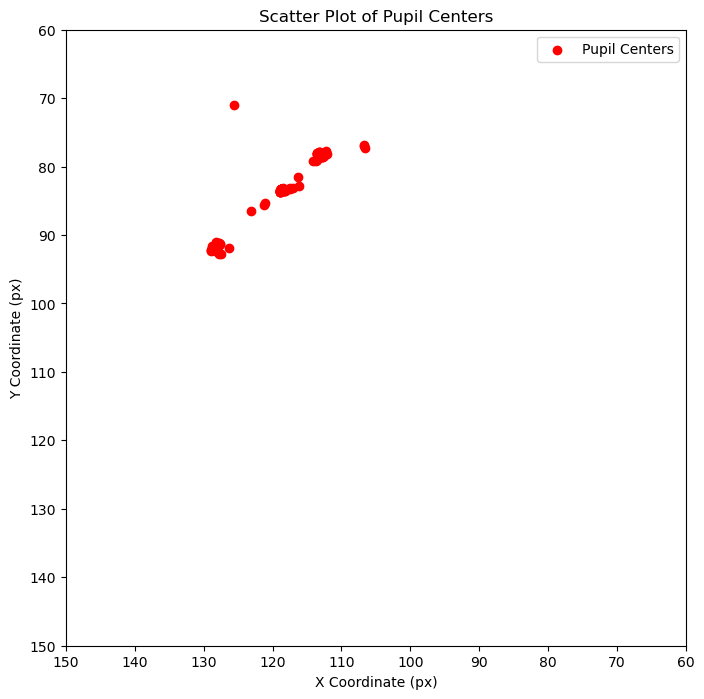

In [19]:
csv_file = f"data/output/test_subject_fefa/random/pupil_coordinates.csv"
iml_util.visualize_pupil_centers(csv_file, video_name)


---
**Task 7 (easy): Determine pupil centers👩‍💻**
1. Inspect the scatter plot and determine the coordinates for the mean pupil center corresponding to each screen coordinate. Fill in the missing values for the keys in the dictionary `D3`
 below. You should pay attention to the `S`
 dictionary representing the screen coordinates. The order of the pupil coordinates has to match the order in the `S`
 dictionary. Use the data for `test_subject_3`
 for the `left`
 eye, that has already been filled in as an example. 


**Important**
If you use the data from the `left`
eye, note that the x coordinates are to be flipped as the left eye rotates opposite to the camera placement compared to the right side. 


---

In [31]:
S = {'grid':      np.array([[100, 100], [960, 100], [1820, 100], [100, 540], [960, 540], [1820, 540], [100, 980],  [960, 980],   [1820, 980]]),
     'circle':    np.array([[1820.0, 540.0],  [1655.7546151624547, 746.9004088069505], [1225.7546151624547, 874.7718937358941], [694.2453848375453, 874.7718937358941],  [264.2453848375453, 746.9004088069506], [100.0, 540.0],[264.2453848375452, 333.0995911930495],[694.2453848375451, 205.22810626410597],[1225.7546151624547, 205.22810626410592],[1655.7546151624547, 333.0995911930494]]),
     'line':      np.array([[100.0, 540.0], [291.1111111111111, 540.0], [482.22222222222223, 540.0], [673.3333333333334, 540.0], [864.4444444444445, 540.0], [1055.5555555555557, 540.0], [1246.6666666666667, 540.0], [1437.7777777777778, 540.0], [1628.888888888889, 540.0], [1820.0, 540.0]]),
     'random':    np.array([[1230, 171], [1226, 535], [221, 566],[960, 370], [1582, 187]])
}

D = {'test_subject_3': {'grid':    np.array([[111.91,95.43], [99.28,92.39], [81.97,90.26], [112.74,103.49], [100.58,99.92], [82.94,96.86], [112.10,109.20], [100.94,105.74], [82.76,104.01]]),
                        'circle':  np.array([[83.24,92.59], [86.38,97.43], [95.16,100.55], [103.75,101.64], [109.55,99.93], [110.71,96.87],[108.69,92.73], [102.51,88.67], [93.08,85.84], [85.66,86.88]]),
                        'line':    np.array([[109.90,94.63], [107.62,93.96], [104.72,92.95],[101.69,91.77], [98.77,90.81], [95.43,90.41],[91.78,89.96], [88.40,89.42], [84.88,88.54], [81.34,88.45]]), 
                        'random':  np.array([[90.89,82.95], [92.09,89.36], [107.81,94.23], [96.36,87.18], [83.69,81.99]])},
      'test_subject_fefa': {'grid':np.array([[130, 81], [120, 79], [99, 77], [130, 94], [121, 89], [100, 86], [132, 103], [120, 99], [102, 95]]),
                        'circle':  np.array([[105, 85], [109, 90], [118, 93], [127, 95], [131, 96], [132, 93], [131, 89], [124, 82], [113, 80], [108, 82]]),
                        'line':    np.array([[128, 91], [126, 90], [124, 88], [120, 87], [118, 86], [113, 85], [110, 84], [106, 83], [103, 82], [101, 82]]),
                        'random':  np.array([[114, 79], [115, 90], [126, 91], [118, 83], [106, 77]]),
     }               
}
# 'random':  np.array([[115, 90], [106, 77], [126, 91], [114, 79], [118, 83]]),

In [32]:
test_subject = 'test_subject_fefa' # change the variable 'test_subject* in accordance to the naming of the folder containing your data and run
iml_util.save_coordinates_to_csv(S, test_subject, 'screen')
iml_util.save_coordinates_to_csv(D[test_subject], test_subject, 'mean_pupil')

Saved grid coordinates to data/output/test_subject_fefa/grid/screen_coordinates.csv
Saved circle coordinates to data/output/test_subject_fefa/circle/screen_coordinates.csv
Saved line coordinates to data/output/test_subject_fefa/line/screen_coordinates.csv
Saved random coordinates to data/output/test_subject_fefa/random/screen_coordinates.csv
Saved grid coordinates to data/output/test_subject_fefa/grid/mean_pupil_coordinates.csv
Saved circle coordinates to data/output/test_subject_fefa/circle/mean_pupil_coordinates.csv
Saved line coordinates to data/output/test_subject_fefa/line/mean_pupil_coordinates.csv
Saved random coordinates to data/output/test_subject_fefa/random/mean_pupil_coordinates.csv



---
**Task 8 (easy): Pupil detection💡**
1. Use the reflections from [Task 2](#Experiment-setup) and [Task 5](#Pupil_detection11) to elaborate on the results displayed in the scatter plot. For example:    - Are the potential pitfalls you discussed in [Task 2](#Experiment-setup) influencing the result? If so, in which context does it become visible? 
    - How are the limitations in the pupil detection expressed in the final result of the pupil centers for each calibration point?
    - Additional observations?




---

In [12]:
#Write your reflections here...